In [1]:
!nvidia-smi

Fri Nov 11 08:26:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    32W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from torchvision.datasets import MNIST
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
device = 'cuda:0'

In [4]:
data_dir = Path('/app/data/mnist')
data_dir.mkdir(exist_ok=True, parents=True)

In [5]:
dataset = MNIST(root=data_dir, train=True, download=True)

In [6]:
pil_img, idx = dataset[0]
np_img = np.array(pil_img)

In [7]:
np_img.shape

(28, 28)

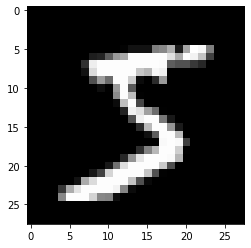

In [8]:
plt.imshow(np_img, cmap='gray')

# Lets add some noise

In [9]:
t_img = torch.tensor(np_img) / 255.

In [10]:
noise = torch.empty(28, 28).normal_(mean=0., std=0.15)

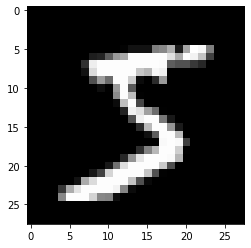

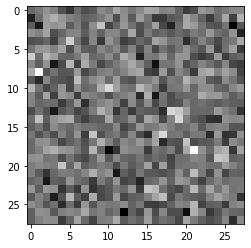

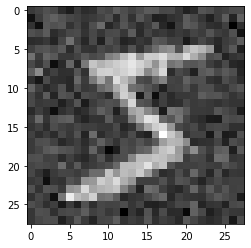

In [11]:
plt.imshow(t_img, cmap='gray')
plt.show()
plt.imshow(noise, cmap='gray')
plt.show()
plt.imshow(t_img+noise, cmap='gray')

# Noise variance scheduling

In [12]:
T = torch.linspace(0, 0.999, 1000)
torch.pi = torch.acos(torch.zeros(1)).item() * 2

In [13]:
torch.pi

3.1415927410125732

In [14]:
s = 0.008

def var_scale(t):
    return torch.cos((t+s)/(1+s)*(torch.pi/2))**2

In [15]:
T_scale = var_scale(T)

In [32]:
a = 1 - T_scale
a_ = np.cumprod(a)

In [33]:
a_

tensor([1.5545e-04, 3.0576e-08, 7.4248e-12, 2.1818e-15, 7.6271e-19, 3.1300e-22,
        1.4897e-25, 8.1378e-29, 5.0581e-32, 3.5491e-35, 2.7917e-38, 2.4467e-41,
        2.3822e-44, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+

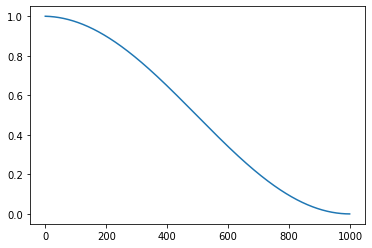

In [16]:
plt.plot(T_scale)

# Apply scaled noise

In [17]:
def q(x_t, b_t):
    noise = torch.empty(x_t.shape).normal_(mean=torch.sqrt(1.-b_t), std=b_t)
    return x_t + noise

In [18]:
noised = q(t_img, T_scale[0])

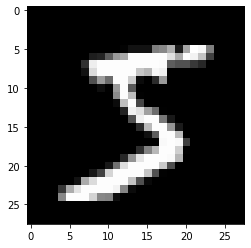

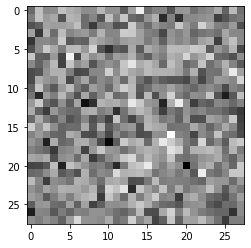

In [19]:
plt.imshow(t_img, cmap='gray')
plt.show()
plt.imshow(noised, cmap='gray')

# VAE definition

In [20]:
from vq_vae import VQVAE
from torch import nn

In [21]:
# p = VanillaVAE(in_channels=3, latent_dim=10)
p = VQVAE(in_channels=1, out_channels=1, embedding_dim=16, num_embeddings=10, img_size=27)

In [22]:
x = torch.rand(2, 1, 28, 28)

In [23]:
noised.unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [24]:
res = p(noised.unsqueeze(0).unsqueeze(0), torch.rand(1, 1))

In [25]:
res[0].shape

torch.Size([1, 1, 28, 28])

## Lets check that this thing could be trained

In [26]:
# p = VQVAE(in_channels=1, out_channels=1, embedding_dim=16, num_embeddings=10, img_size=27).to(device)

# optimizer = torch.optim.AdamW(p.parameters(), lr=2e-5, weight_decay=1e-5)

In [27]:
# sample_input = t_img.unsqueeze(0).unsqueeze(0).to(device)
# sample_t = torch.rand(1,1).to(device)

In [28]:
# loss_print_freq = 200

# for i in range(10000):
#     recon, inp, vq_loss = p(sample_input, sample_t)
#     losses_dict = p.loss_function(recon, inp, vq_loss)
    
#     loss = losses_dict['loss']
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
#     if i % loss_print_freq == 0:
#             print(loss)

In [29]:
# plt.imshow(noised.squeeze().detach().cpu().numpy())

In [30]:
# recon, inp, vq_loss = p(noised.unsqueeze(0).unsqueeze(0).to(device))

In [31]:
# plt.imshow(recon.squeeze().detach().cpu().numpy())